# VECHAIN Trading Signal Features

### Import Libraries and Dependencies

In [1]:
import pandas as pd
from pandas import DataFrame
import requests
import os
import os.path
import datetime as dt
import json
import numpy as np
from datetime import timedelta, datetime
from dateutil import parser
import math
%matplotlib inline
from matplotlib import pyplot as plt

from dotenv import load_dotenv
load_dotenv()

import warnings
warnings.filterwarnings('ignore')

In /opt/anaconda3/envs/env1/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /opt/anaconda3/envs/env1/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In /opt/anaconda3/envs/env1/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


### Get COIN data

In [2]:
# Load environment variables 
binance_api_key = os.getenv("BINANCE_API_KEY")
binance_secret_key= os.getenv("BINANCE_SECRET_KEY")

In [3]:
## Set up client 
from binance.client import Client
binance_client = Client(api_key=binance_api_key, api_secret=binance_secret_key)

# Constants
binsizes = {"1m": 1, "5m": 5, "1h": 60, "1d": 1440}
batch_size = 750

# Create collecting new data function
def minutes_of_new_data(symbol, kline_size, data, source):
    if len(data) > 0:  old = parser.parse(data["timestamp"].iloc[-1])
    elif source == "binance": old = datetime.strptime('1 Jan 2015', '%d %b %Y')
    if source == "binance": new = pd.to_datetime(binance_client.get_klines(symbol=symbol, interval=kline_size)[-1][0], unit='ms')
    return old, new

# Create function to retreive tickers and timestamps
def get_all_binance(symbol, kline_size, save = False):
    filename = '%s-%s-data.csv' % (symbol, kline_size)
    if os.path.isfile(filename): data_df = pd.read_csv(filename)
    else: data_df = pd.DataFrame()
    oldest_point, newest_point = minutes_of_new_data(symbol, kline_size, data_df, source = "binance")
    delta_min = (newest_point - oldest_point).total_seconds()/60
    available_data = math.ceil(delta_min/binsizes[kline_size])
    if oldest_point == datetime.strptime('1 Jan 2015', '%d %b %Y'): print('Downloading all available %s data for %s. Be patient..!' % (kline_size, symbol))
    else: print('Downloading %d minutes of new data available for %s, i.e. %d instances of %s data.' % (delta_min, symbol, available_data, kline_size))
    klines = binance_client.get_historical_klines(symbol, kline_size, oldest_point.strftime("%d %b %Y %H:%M:%S"), newest_point.strftime("%d %b %Y %H:%M:%S"))
    data = pd.DataFrame(klines, columns = ['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_av', 'trades', 'tb_base_av', 'tb_quote_av', 'ignore' ])
    data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
    if len(data_df) > 0:
        temp_df = pd.DataFrame(data)
        data_df = data_df.append(temp_df)
    else: data_df = data
    data_df.set_index('timestamp', inplace=True)
    if save: data_df.to_csv(filename)
    print('All caught up..!')
    return data_df

In [5]:
# Get vechain data
vet_data=get_all_binance('VETBTC', '1h')
vet_data.head()

All caught up..!


,open,high,low,close,volume,close_time,quote_av,trades,tb_base_av,tb_quote_av,ignore
timestamp,,,,,,,,,,,
2018-07-25 04:00:00,0.00000300,0.00000300,0.00000242,0.00000262,313149726.00000000,1532494799999,817.87571825,6804,166006854.00000000,436.76017934,0
2018-07-25 05:00:00,0.00000258,0.00000264,0.00000253,0.00000262,53266947.00000000,1532498399999,137.65478612,2235,30317135.00000000,78.49932764,0
2018-07-25 06:00:00,0.00000262,0.00000266,0.00000255,0.00000256,51329133.00000000,1532501999999,133.21059982,2367,27149823.00000000,70.62251135,0
2018-07-25 07:00:00,0.00000256,0.00000260,0.00000252,0.00000258,27692582.00000000,1532505599999,71.03679491,2229,14584941.00000000,37.51642375,0
2018-07-25 08:00:00,0.00000258,0.00000260,0.00000251,0.00000254,30060366.00000000,1532509199999,76.68867857,2986,11313789.00000000,29.05391403,0


In [7]:
vet_data=vet_data.loc[:,['high', 'low', 'close']]

In [8]:
vet_data=vet_data.apply(pd.to_numeric)

In [9]:
vet_data = vet_data.loc['2020-06-11 01:00:00':'2020-07-11 01:00:00']

In [10]:
vet_data.head()

,high,low,close
timestamp,,,
2020-06-11 01:00:00,9.900000e-07,9.200000e-07,9.900000e-07
2020-06-11 02:00:00,1.010000e-06,9.700000e-07,9.700000e-07
2020-06-11 03:00:00,1.000000e-06,9.700000e-07,9.900000e-07
2020-06-11 04:00:00,1.010000e-06,9.800000e-07,9.900000e-07
2020-06-11 05:00:00,1.000000e-06,9.600000e-07,9.800000e-07


### Drop NAs and Calculate Daily Returns 

In [11]:
# Drop NAs and calculate daily percent return
vet_data['daily_return'] = vet_data['close'].dropna().pct_change()
vet_data.head()

,high,low,close,daily_return
timestamp,,,,
2020-06-11 01:00:00,9.900000e-07,9.200000e-07,9.900000e-07,NaN
2020-06-11 02:00:00,1.010000e-06,9.700000e-07,9.700000e-07,-0.020202
2020-06-11 03:00:00,1.000000e-06,9.700000e-07,9.900000e-07,0.020619
2020-06-11 04:00:00,1.010000e-06,9.800000e-07,9.900000e-07,0.000000
2020-06-11 05:00:00,1.000000e-06,9.600000e-07,9.800000e-07,-0.010101


### Construct Stochastic Oscillator SOSC (Trading Signal, Feature One)

In [12]:
#Create the "L14" column in the DataFrame
vet_data['L14'] = vet_data['low'].rolling(window=14).min()
#Create the "H14" column in the DataFrame
vet_data['H14'] = vet_data['high'].rolling(window=14).max()
#Create the "%K" column in the DataFrame
vet_data['%K'] = 100*((vet_data['close'] - vet_data['L14']) / (vet_data['H14'] - vet_data['L14']))
#Create the "%D" column in the DataFrame
vet_data['%D'] = vet_data['%K'].rolling(window=3).mean()

In [13]:
#Create a column in the DataFrame showing "TRUE" if sell entry signal is given and "FALSE" otherwise. 
#A sell is initiated when the %K line crosses down through the %D line and the value of the oscillator is above 80 
vet_data['SOSC Sell Entry'] = ((vet_data['%K'] < vet_data['%D']) & (vet_data['%K'].shift(1) > vet_data['%D'].shift(1))) & (vet_data['%D'] > 80) 
#Create a column in the DataFrame showing "TRUE" if sell exit signal is given and "FALSE" otherwise. 
#A sell exit signal is given when the %K line crosses back up through the %D line 
vet_data['SOSC Sell Exit'] = ((vet_data['%K'] > vet_data['%D']) & (vet_data['%K'].shift(1) < vet_data['%D'].shift(1))) 
#create a placeholder column to populate with short positions (-1 for short and 0 for flat) using boolean values created above 
vet_data['SOSC Short'] = np.nan 
vet_data.loc[vet_data['SOSC Sell Entry'],'SOSC Short'] = -1 
vet_data.loc[vet_data['SOSC Sell Exit'],'SOSC Short'] = 0 
#Set initial position on day 1 to flat 
vet_data['SOSC Short'][0] = 0 
#Forward fill the position column to represent the holding of positions through time 
vet_data['SOSC Short'] = vet_data['SOSC Short'].fillna(method='pad') 
#Create a column in the DataFrame showing "TRUE" if buy entry signal is given and "FALSE" otherwise. 
#A buy is initiated when the %K line crosses up through the %D line and the value of the oscillator is below 20 
vet_data['SOSC Buy Entry'] = ((vet_data['%K'] > vet_data['%D']) & (vet_data['%K'].shift(1) < vet_data['%D'].shift(1))) & (vet_data['%D'] < 20) 
#Create a column in the DataFrame showing "TRUE" if buy exit signal is given and "FALSE" otherwise. 
#A buy exit signal is given when the %K line crosses back down through the %D line 
vet_data['SOSC Buy Exit'] = ((vet_data['%K'] < vet_data['%D']) & (vet_data['%K'].shift(1) > vet_data['%D'].shift(1))) 
#create a placeholder column to polulate with long positions (1 for long and 0 for flat) using boolean values created above 
vet_data['SOSC Long'] = np.nan  
vet_data.loc[vet_data['SOSC Buy Entry'],'SOSC Long'] = 1  
vet_data.loc[vet_data['SOSC Buy Exit'],'SOSC Long'] = 0  
#Set initial position on day 1 to flat 
vet_data['SOSC Long'][0] = 0  
#Forward fill the position column to represent the holding of positions through time 
vet_data['SOSC Long'] = vet_data['SOSC Long'].fillna(method='pad') 
#Add Long and Short positions together to get final strategy position (1 for long, -1 for short and 0 for flat) 
vet_data['SOSC Position'] = vet_data['SOSC Long'] + vet_data['SOSC Short']
vet_data.head()

,high,low,close,daily_return,L14,H14,%K,%D,SOSC Sell Entry,SOSC Sell Exit,SOSC Short,SOSC Buy Entry,SOSC Buy Exit,SOSC Long,SOSC Position
timestamp,,,,,,,,,,,,,,,
2020-06-11 01:00:00,9.900000e-07,9.200000e-07,9.900000e-07,NaN,NaN,NaN,NaN,NaN,False,False,0.0,False,False,0.0,0.0
2020-06-11 02:00:00,1.010000e-06,9.700000e-07,9.700000e-07,-0.020202,NaN,NaN,NaN,NaN,False,False,0.0,False,False,0.0,0.0
2020-06-11 03:00:00,1.000000e-06,9.700000e-07,9.900000e-07,0.020619,NaN,NaN,NaN,NaN,False,False,0.0,False,False,0.0,0.0
2020-06-11 04:00:00,1.010000e-06,9.800000e-07,9.900000e-07,0.000000,NaN,NaN,NaN,NaN,False,False,0.0,False,False,0.0,0.0
2020-06-11 05:00:00,1.000000e-06,9.600000e-07,9.800000e-07,-0.010101,NaN,NaN,NaN,NaN,False,False,0.0,False,False,0.0,0.0


### Plot the oscillator %K, for each session and %D the three-day simple moving average of closing prices

Text(0.5, 1.0, 'oscillator')

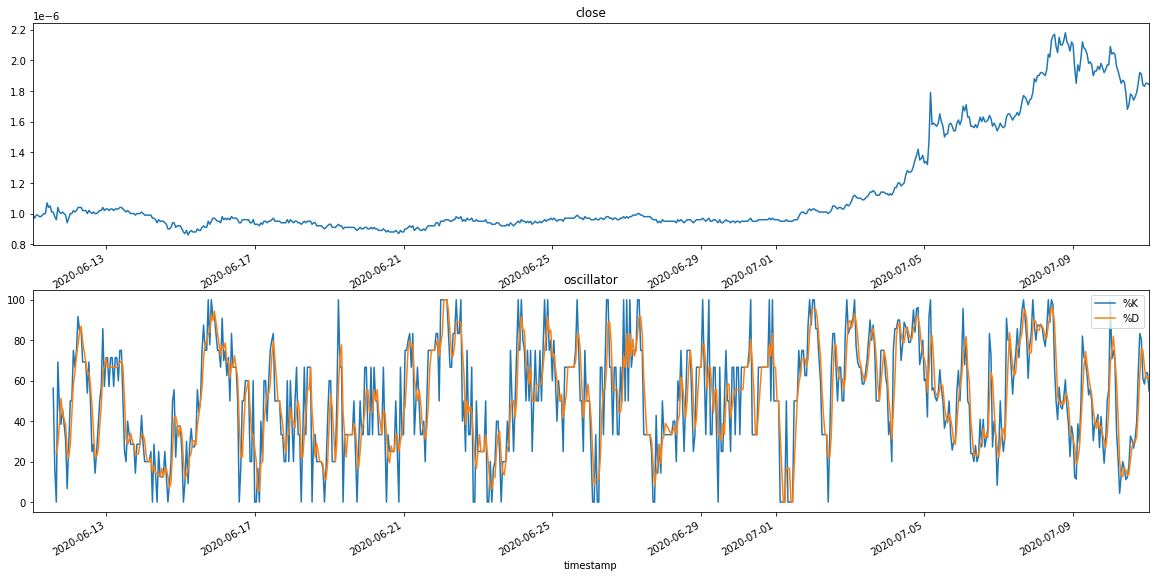

In [14]:
# Plot %K and %D of closing prices
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(20,10))
vet_data['close'].plot(ax=axes[0]); axes[0].set_title('close')
vet_data[['%K','%D']].plot(ax=axes[1]); axes[1].set_title('oscillator')

### Construct a RSI (Trading Signal, Feature Two)

In [16]:
# Calculate change in closing prices day over day
vet_data['delta'] = vet_data['close'].diff()
vet_data = vet_data.dropna()

# Make the positive gains (up) and negative gains (down) Series
up, down = vet_data['delta'].copy(), vet_data['delta'].copy()
up[up < 0] = 0
down[down > 0] = 0

window_length = 14

# Calculate the EWMA
roll_up1 = up.ewm(span=window_length).mean()
roll_down1 = down.abs().ewm(span=window_length).mean()

# Calculate the RSI based on EWMA
RS1 = roll_up1 / roll_down1
vet_data['RSI1'] = 100.0 - (100.0 / (1.0 + RS1))

# Construct a short/long trading signal RSI
vet_data['RSI short'] = np.where(vet_data['RSI1'] > 70, -1.0, 0.0)
vet_data['RSI long'] = np.where(vet_data['RSI1'] < 30, 1.0, 0.0)
vet_data['RSI Position'] = vet_data['RSI short'] + vet_data['RSI long']

### Plot RSI 

Text(0.5, 1.0, 'RSI')

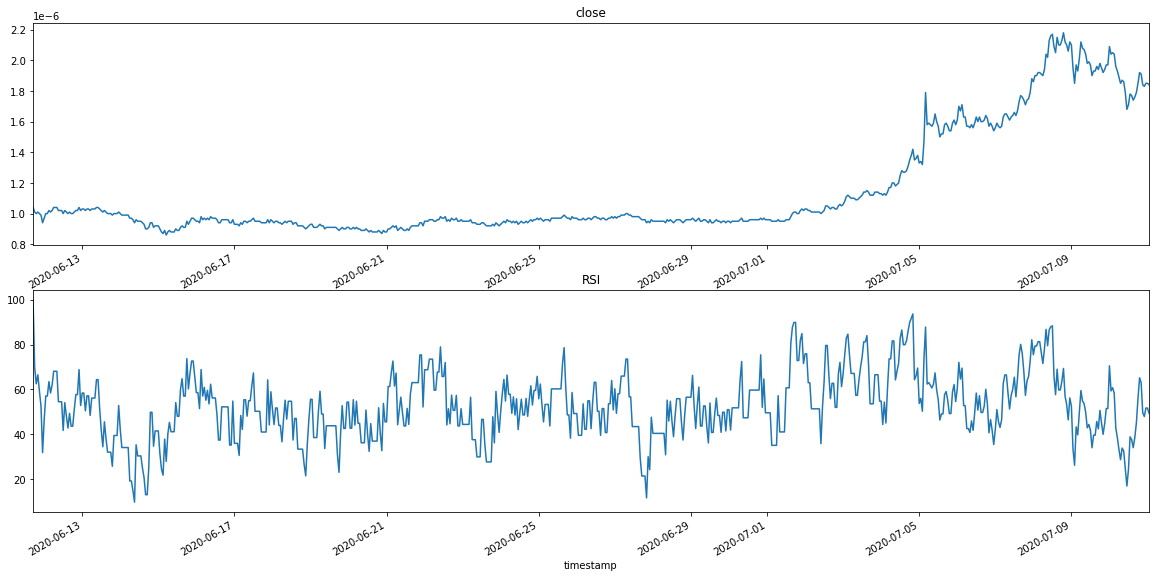

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=1,figsize=(20,10))
vet_data['close'].plot(ax=axes[0]); axes[0].set_title('close')
vet_data['RSI1'].plot(ax=axes[1]); axes[1].set_title('RSI')

### Construct a RSI + MACD (Trading Signal, Feature Three)

In [18]:
short_window = 7
long_window = 14

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
vet_data['fast_close'] = vet_data['close'].ewm(halflife=short_window).mean()
vet_data['slow_close'] = vet_data['close'].ewm(halflife=long_window).mean()

vet_data.tail()

,high,low,close,daily_return,L14,H14,%K,%D,SOSC Sell Entry,SOSC Sell Exit,...,SOSC Buy Exit,SOSC Long,SOSC Position,delta,RSI1,RSI short,RSI long,RSI Position,fast_close,slow_close
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-07-10 21:00:00,0.000002,0.000002,0.000002,-0.036649,0.000002,0.000002,61.111111,75.000000,False,False,...,True,0.0,0.0,-7.000000e-08,49.618048,0.0,0.0,0.0,0.000002,0.000002
2020-07-10 22:00:00,0.000002,0.000002,0.000002,-0.005435,0.000002,0.000002,58.333333,66.666667,False,False,...,False,0.0,0.0,-1.000000e-08,47.937829,0.0,0.0,0.0,0.000002,0.000002
2020-07-10 23:00:00,0.000002,0.000002,0.000002,0.010929,0.000002,0.000002,63.888889,61.111111,False,True,...,False,0.0,0.0,2.000000e-08,51.711369,0.0,0.0,0.0,0.000002,0.000002
2020-07-11 00:00:00,0.000002,0.000002,0.000002,0.000000,0.000002,0.000002,63.888889,62.037037,False,False,...,False,0.0,0.0,0.000000e+00,51.711369,0.0,0.0,0.0,0.000002,0.000002
2020-07-11 01:00:00,0.000002,0.000002,0.000002,-0.005405,0.000002,0.000002,54.838710,60.872162,False,False,...,True,0.0,0.0,-1.000000e-08,49.331167,0.0,0.0,0.0,0.000002,0.000002


In [20]:
#Create a column in the DataFrame showing "TRUE" if sell entry signal is given and "FALSE" otherwise. 
#A sell is initiated when the %K line crosses down through the %D line and the value of the oscillator is above 80 
vet_data['RSI/MACD Sell Entry'] = ((vet_data['fast_close'] < vet_data['slow_close']) & (vet_data['RSI1'] > 70)) 
#Create a column in the DataFrame showing "TRUE" if sell exit signal is given and "FALSE" otherwise. 
#A sell exit signal is given when the %K line crosses back up through the %D line 
vet_data['RSI/MACD Sell Exit'] = ((vet_data['fast_close'] > vet_data['slow_close']))
#create a placeholder column to populate with short positions (-1 for short and 0 for flat) using boolean values created above 
vet_data['RSI/MACD Short'] = np.nan 
vet_data.loc[vet_data['RSI/MACD Sell Entry'],'RSI/MACD Short'] = -1 
vet_data.loc[vet_data['RSI/MACD Sell Exit'],'RSI/MACD Short'] = 0 
#Set initial position on day 1 to flat 
vet_data['RSI/MACD Short'][0] = 0 
#Forward fill the position column to represent the holding of positions through time 
vet_data['RSI/MACD Short'] = vet_data['RSI/MACD Short'].fillna(method='pad') 
#Create a column in the DataFrame showing "TRUE" if buy entry signal is given and "FALSE" otherwise. 
#A buy is initiated when the %K line crosses up through the %D line and the value of the oscillator is below 20 
vet_data['RSI/MACD Buy Entry'] = ((vet_data['fast_close'] > vet_data['slow_close']) & (vet_data['RSI1'] < 30)) 
#Create a column in the DataFrame showing "TRUE" if buy exit signal is given and "FALSE" otherwise. 
#A buy exit signal is given when the %K line crosses back down through the %D line 
vet_data['RSI/MACD Buy Exit'] = (vet_data['fast_close'] < vet_data['slow_close'])
#create a placeholder column to polulate with long positions (1 for long and 0 for flat) using boolean values created above 
vet_data['RSI/MACD Long'] = np.nan  
vet_data.loc[vet_data['RSI/MACD Buy Entry'],'RSI/MACD Long'] = 1  
vet_data.loc[vet_data['RSI/MACD Buy Exit'],'RSI/MACD Long'] = 0  
#Set initial position on day 1 to flat 
vet_data['RSI/MACD Long'][0] = 0  
#Forward fill the position column to represent the holding of positions through time 
vet_data['RSI/MACD Long'] = vet_data['RSI/MACD Long'].fillna(method='pad') 
#Add Long and Short positions together to get final strategy position (1 for long, -1 for short and 0 for flat) 
vet_data['RSI/MACD Position'] = vet_data['RSI/MACD Long'] + vet_data['RSI/MACD Short']

vet_data.tail()

,high,low,close,daily_return,L14,H14,%K,%D,SOSC Sell Entry,SOSC Sell Exit,...,RSI Position,fast_close,slow_close,RSI/MACD Sell Entry,RSI/MACD Sell Exit,RSI/MACD Short,RSI/MACD Buy Entry,RSI/MACD Buy Exit,RSI/MACD Long,RSI/MACD Position
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-07-10 21:00:00,0.000002,0.000002,0.000002,-0.036649,0.000002,0.000002,61.111111,75.000000,False,False,...,0.0,0.000002,0.000002,False,False,0.0,False,True,0.0,0.0
2020-07-10 22:00:00,0.000002,0.000002,0.000002,-0.005435,0.000002,0.000002,58.333333,66.666667,False,False,...,0.0,0.000002,0.000002,False,False,0.0,False,True,0.0,0.0
2020-07-10 23:00:00,0.000002,0.000002,0.000002,0.010929,0.000002,0.000002,63.888889,61.111111,False,True,...,0.0,0.000002,0.000002,False,False,0.0,False,True,0.0,0.0
2020-07-11 00:00:00,0.000002,0.000002,0.000002,0.000000,0.000002,0.000002,63.888889,62.037037,False,False,...,0.0,0.000002,0.000002,False,False,0.0,False,True,0.0,0.0
2020-07-11 01:00:00,0.000002,0.000002,0.000002,-0.005405,0.000002,0.000002,54.838710,60.872162,False,False,...,0.0,0.000002,0.000002,False,False,0.0,False,True,0.0,0.0


### Plot MACD and RSI 

Text(0.5, 1.0, 'MACD')

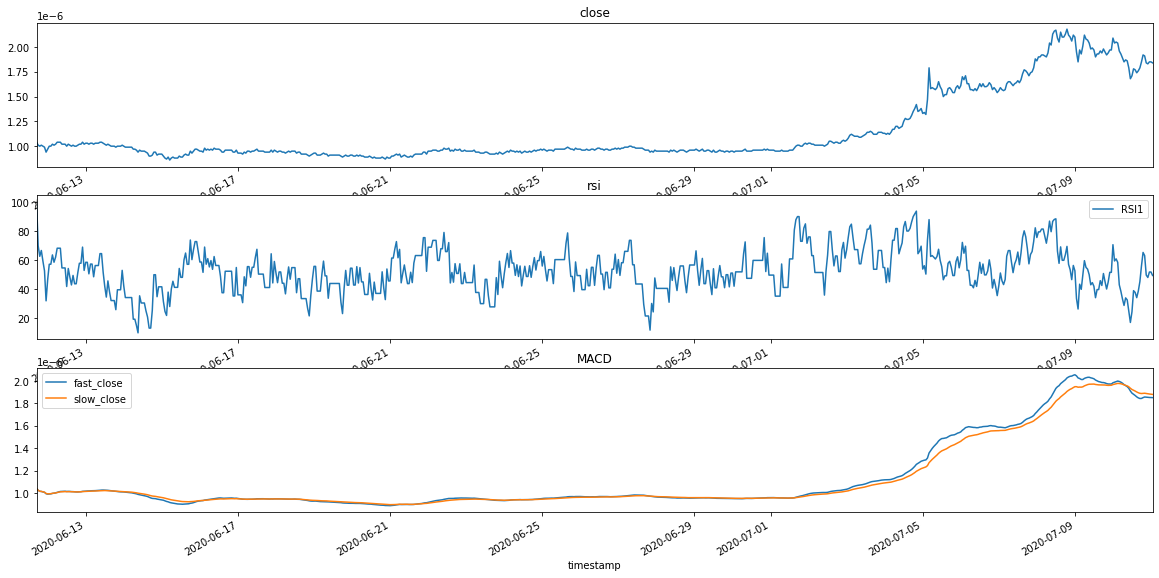

In [21]:
# Plot MACD, RSI
fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(20,10))
vet_data['close'].plot(ax=axes[0]); axes[0].set_title('close')
vet_data[['RSI1']].plot(ax=axes[1]); axes[1].set_title('rsi')
vet_data[['fast_close', 'slow_close']].plot(ax=axes[2]); axes[2].set_title('MACD')

### Plot Strategies Positions

Text(0.5, 1.0, 'RSI/MACD Position')

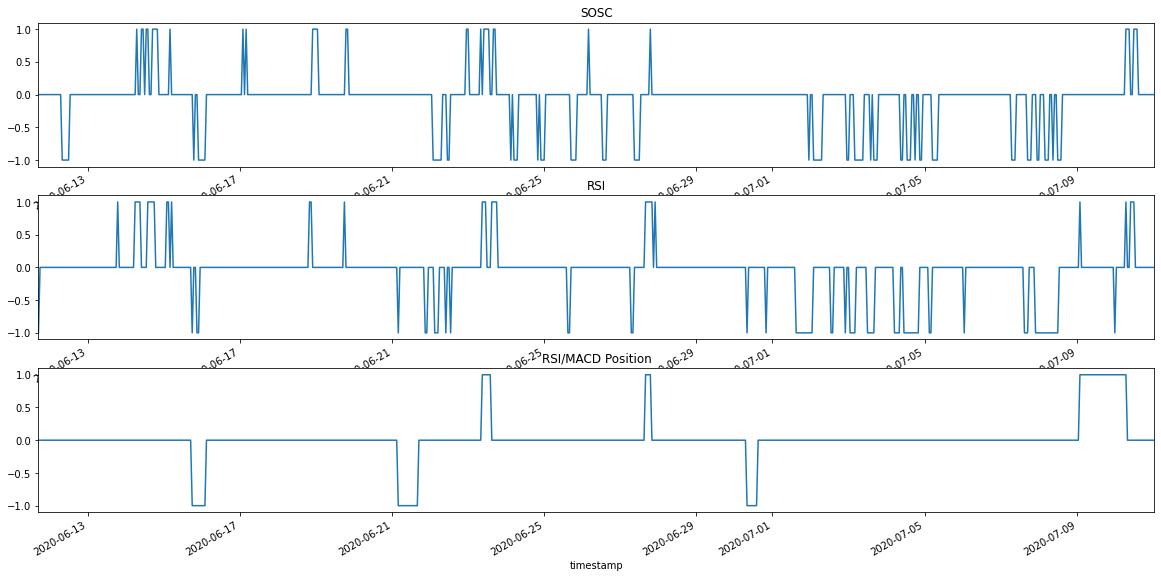

In [22]:
# Plot MACD, RSI
fig, axes = plt.subplots(nrows=3, ncols=1,figsize=(20,10))
vet_data['SOSC Position'].plot(ax=axes[0]); axes[0].set_title('SOSC')
vet_data['RSI Position'].plot(ax=axes[1]); axes[1].set_title('RSI')
vet_data['RSI/MACD Position'].plot(ax=axes[2]); axes[2].set_title('RSI/MACD Position')

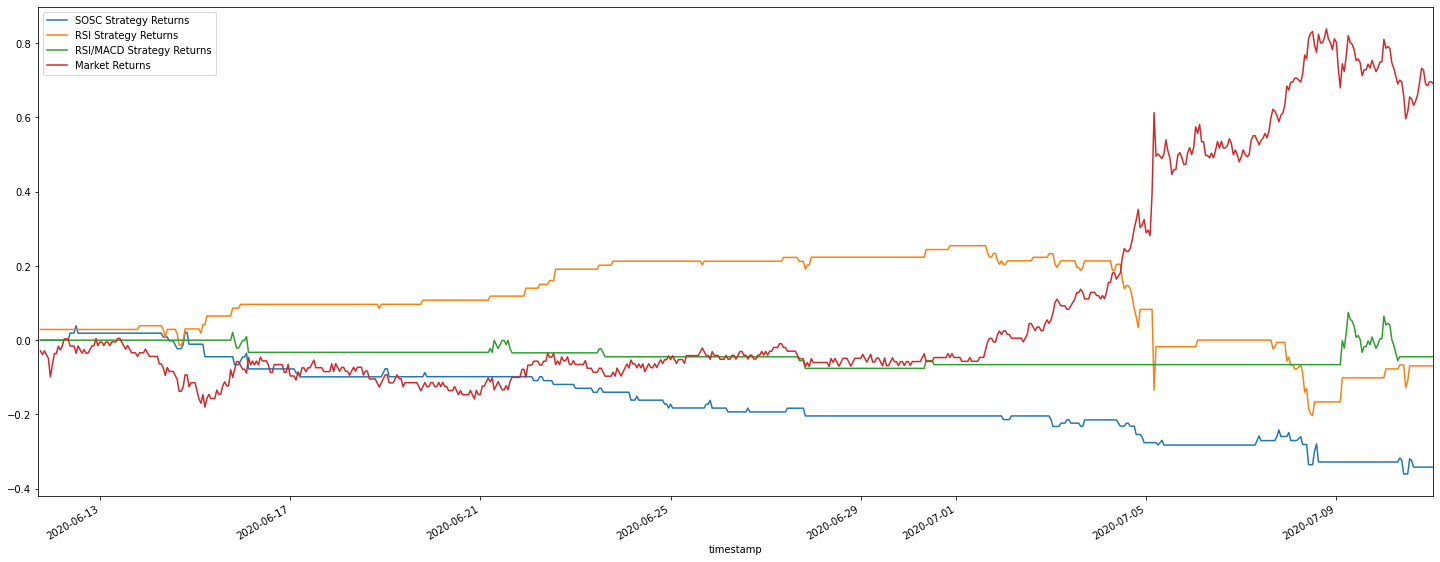

In [25]:
#Set up a column holding the daily vechain returns
vet_data['Market Returns'] = vet_data['close'].pct_change()
#Create column for StrategY Returns by multiplying the daily vechain returns by the position that was held at close
#of business the previous day
vet_data['SOSC Strategy Returns'] = vet_data['Market Returns'] * vet_data['SOSC Position'].shift(1)
vet_data['RSI Strategy Returns'] = vet_data['Market Returns'] * vet_data['RSI Position'].shift(1)
vet_data['RSI/MACD Strategy Returns'] = vet_data['Market Returns'] * vet_data['RSI/MACD Position'].shift(1)

#Finally plot the strategy returns versus vechain returns
vet_data[['SOSC Strategy Returns', 'RSI Strategy Returns','RSI/MACD Strategy Returns','Market Returns']].cumsum().plot(figsize=(25,10))

Summary
 - Buy and Hold <font color=red>VECHAIN
    